In [127]:
"""
Part 4
"""
import math
import numpy as np
import matplotlib.pyplot as plt

data = np.load('p4_data/mds-population.npz')
print(data['D'].shape)
print(data['population_list'].shape)

(42, 42)
(42,)


In [128]:
"""
Part 4.A.I and 4.A.II
"""
from scipy.spatial import distance
from sklearn.manifold import MDS

def MDS_data(data, dimensions):
    embedding = MDS(n_components=dimensions)
    return embedding.fit_transform(data)

def recreate_D(transformed_data):
    dim = transformed_data.shape[0]
    r_D = np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            r_D[i][j] = distance.euclidean(transformed_data[i],transformed_data[j])

    return r_D

def compare_Ds(D1, D2):
    dif = 0

C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


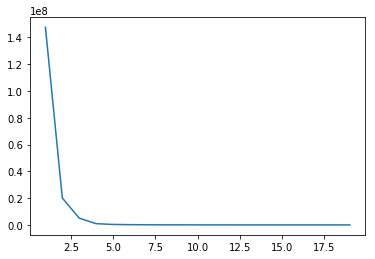

In [129]:
"""
Part 4.A.I and 4.A.II
"""
from sklearn.manifold import MDS

def MDS_data(data, dimensions):
    embedding = MDS(n_components=dimensions)
    return embedding.fit_transform(data), embedding.stress_

#recreate D, compare to original to get difference
D_difs = []
for i in range(1,20):
    data_transformed, stress = MDS_data(data['D'], i)
    D_difs.append(stress)

xvals = [i for i in range(1, 20)]
plt.plot(xvals, D_difs)

C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


<Figure size 432x288 with 0 Axes>

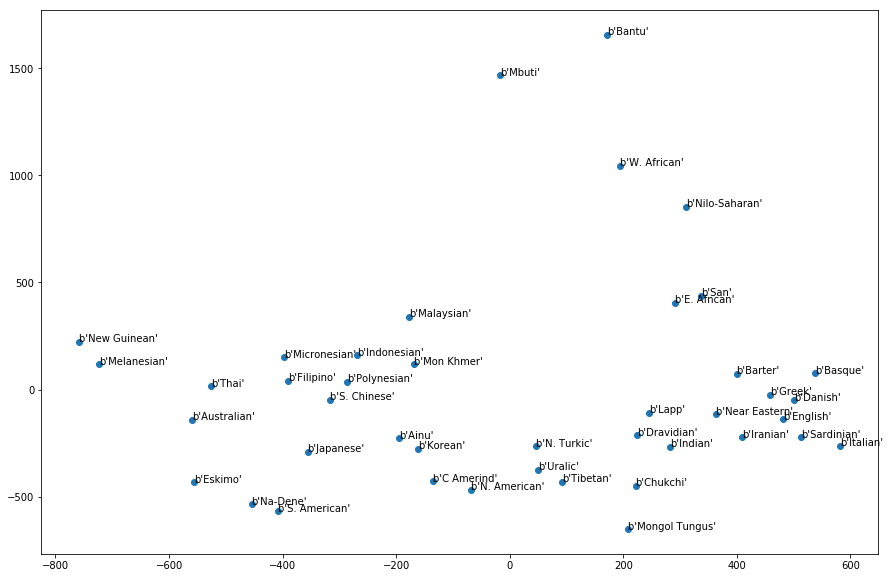

In [130]:
"""
Part 4.A.III
"""
plt.clf()
transformed_data,_ = MDS_data(data['D'], 2)
xs = [x for x,_ in transformed_data]
ys = [y for _,y in transformed_data]
labels = data['population_list']
plt.figure(figsize=(15,10))
plt.scatter(xs,ys)
for i in range(len(labels)):
    plt.annotate(labels[i], (xs[i], ys[i]))

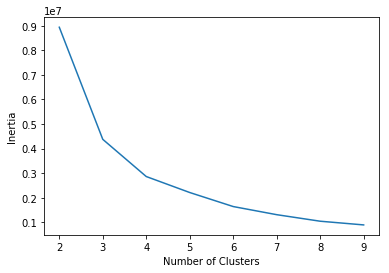

In [131]:
"""
Part 4.B
"""
from sklearn.cluster import KMeans

xvals = []
yvals = []
kmeans_arr = []
for k in range(2,10):
    xvals.append(k)
    kmeans = KMeans(n_clusters=k).fit(transformed_data)
    kmeans_arr.append(kmeans)
    yvals.append(kmeans.inertia_)

plt.clf()
plt.plot(xvals, yvals)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

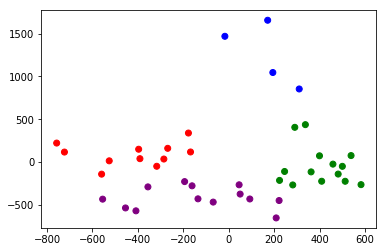

In [132]:
"""
Part 4.B
"""
km = kmeans_arr[2]
labels = km.labels_
cols = []
for l in labels:
    if l == 0:
        cols.append('r')
    elif l == 1:
        cols.append('g')
    elif l == 2:
        cols.append('b')
    else:
        cols.append('purple')
plt.clf()
plt.scatter(xs,ys, c=cols)

<Figure size 432x288 with 0 Axes>

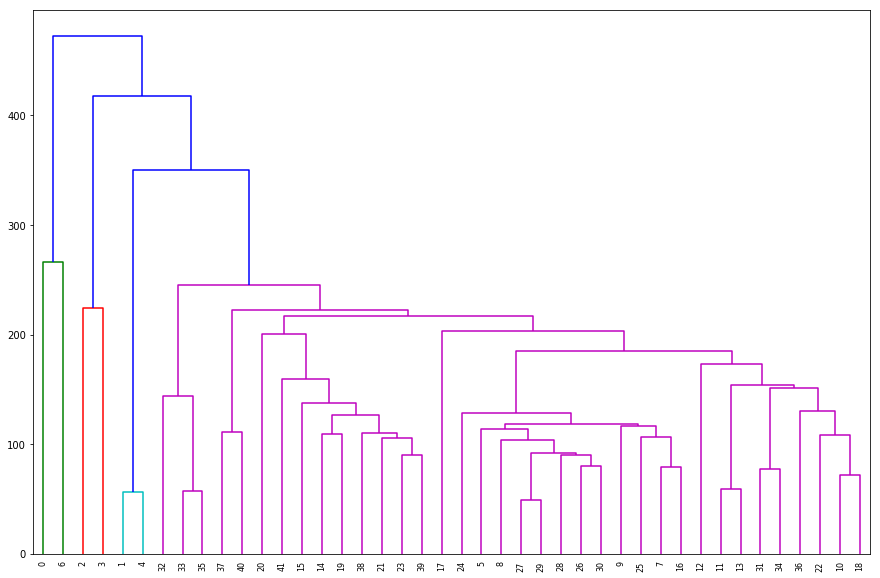

In [133]:
"""
Part 4.C
"""
from scipy.cluster import hierarchy

z = hierarchy.linkage(transformed_data)
plt.clf()
plt.figure(figsize=(15,10))
hierarchy.dendrogram(z)
plt.show()

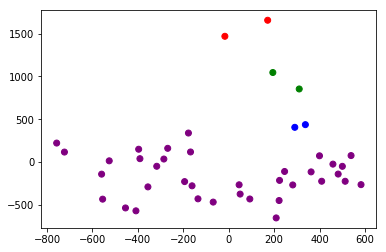

In [134]:
labels = hierarchy.fcluster(z, 300, criterion='distance')
cols = []
for l in labels:
    if l == 1:
        cols.append('r')
    elif l == 2:
        cols.append('g')
    elif l == 3:
        cols.append('b')
    else:
        cols.append('purple')
        
plt.clf()
plt.scatter(xs,ys, c=cols)

Converged in 4 iterations


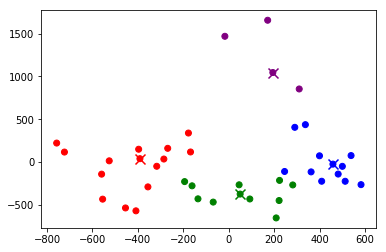

In [135]:
"""
Part 4.D
"""
import random

def manhattan_dist(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def get_k_medoid_labels(centers, data):
    labels = []
    for d in data:
        closest = 1000000
        best_label = -1
        for i in range(len(centers)):
            c = centers[i]
            dist = manhattan_dist(c,d)
            if dist < closest:
                closest = dist
                best_label = i
        labels.append(best_label)
    return labels

def get_cost(centers, data, labels=None):
    cost = 0
    if labels == None: labels = [0 for i in range(data.shape[0])]
    for i in range(data.shape[0]):
        l = labels[i]
        d = data[i]
        c = centers[l]
        cost += manhattan_dist(d,c)
    return cost

def grab_related_points(data, labels, desired_label):
    # grab all related points
    possible_points = []
    for j in range(len(labels)):
        l = labels[j]
        d = data[j]
        if l == desired_label:
            possible_points.append(d)
    return np.array(possible_points)

def get_best_medoid(current_cost, possible_points):
    best_cost = 100000000
    best_point = None

    # compare against all other possible cluster centers
    for p in possible_points:
        cur_cost = get_cost([p], possible_points)
        if cur_cost < best_cost:
            best_cost = cur_cost
            best_point = p
    return best_point

def k_medoids(k, data):
    # select k random points initially
    centers = []
    for i in range(k):
        centers.append(data[random.randint(0,data.shape[0]-1)])
    labels = get_k_medoid_labels(centers, data)
    
    cost = 1000000000.0
    new_cost = get_cost(centers, data, labels)
    iterations = 0
    while new_cost < cost:
        cost = new_cost
        iterations += 1
        
        # for each center
        for i in range(len(centers)):
            c = centers[i]
            
            possible_points = grab_related_points(data, labels, i)
            
            # get current w/n cluster cost
            cluster_cost = get_cost([c], possible_points)
            centers[i] = get_best_medoid(cluster_cost, possible_points)
        
        # grab new cost
        labels = get_k_medoid_labels(centers, data)
        new_cost = get_cost(centers, data, labels)
    
    return centers, labels, iterations

c,labels, iterations = k_medoids(4, transformed_data)

print('Converged in {0} iterations'.format(iterations))

cols = []
for l in labels:
    if l == 0:
        cols.append('r')
    elif l == 1:
        cols.append('g')
    elif l == 2:
        cols.append('b')
    else:
        cols.append('purple')
        
plt.clf()
plt.subplot(111)
plt.scatter(xs,ys, c=cols)
plt.scatter([c[0][0]], [c[0][1]], c='r', marker='x', s=[100])
plt.scatter([c[1][0]], [c[1][1]], c='g', marker='x', s=[100])
plt.scatter([c[2][0]], [c[2][1]], c='b', marker='x', s=[100])
plt.scatter([c[3][0]], [c[3][1]], c='purple', marker='x', s=[100])